# Fashion MNIST Noisy CNN Autoencoder

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Prepare the dataset

In [4]:
def map_image(image, label):
  '''Normalizes the image. Returns image as input and label.'''
  image = tf.cast(image, dtype=tf.float32)
  image /= 255.0

  noise_factor = 0.5
  factor = noise_factor * tf.random.normal(shape=image.shape)
  image_noisy = image + factor
  image_noisy = tf.clip_by_value(image_noisy, 0.0, 1.0)
  return image_noisy, image

In [5]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tfds.load('fashion_mnist', as_supervised=True, split='train')
train_dataset = train_dataset.map(map_image)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tfds.load('fashion_mnist', as_supervised=True, split='test')
test_dataset = test_dataset.map(map_image)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

## Define the model

In [6]:
def encoder(inputs):
  conv_1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
  max_pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_1)

  conv_2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(max_pool_1)
  max_pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_2)
  return max_pool_2

In [7]:
def bottle_neck(inputs):
  bottle_neck = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(inputs)
  encoder_visualization = tf.keras.layers.Conv2D(1, 3, activation='sigmoid', padding='same')(bottle_neck)
  return bottle_neck, encoder_visualization

In [8]:
def decoder(inputs):
  '''Defines the decoder path to upsample back to the original image size.'''
  conv_1 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(inputs)
  up_sample_1 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv_1)

  conv_2 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(up_sample_1)
  up_sample_2 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv_2)

  conv_3 = tf.keras.layers.Conv2D(1, 3, activation='sigmoid', padding='same')(up_sample_2)
  return conv_3

In [9]:
def convolutional_autoencoder():
  '''Builds the entire autoencoder model.'''
  inputs = tf.keras.layers.Input(shape=(28, 28, 1))
  encoder_output = encoder(inputs)
  bottleneck_output, encoder_visualization = bottle_neck(encoder_output)
  decoder_output = decoder(bottleneck_output)

  encoder_model = tf.keras.Model(inputs=inputs, outputs=encoder_visualization)
  model = tf.keras.Model(inputs=inputs, outputs=decoder_output)  
  return model, encoder_model

In [10]:
convolutional_model, convolutional_encoder_model = convolutional_autoencoder()
convolutional_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         2950

In [11]:
convolutional_model.compile(optimizer=tf.keras.optimizers.Adam(), 
                            loss='binary_crossentropy')

## Train the model

In [12]:
train_steps = 60000 // BATCH_SIZE
valid_steps = 60000 // BATCH_SIZE

history = convolutional_model.fit(train_dataset, steps_per_epoch=train_steps, 
                                  validation_data=test_dataset, validation_steps=valid_steps, 
                                  epochs=40)

Epoch 1/40
468/468 [==============================] - 53s 42ms/step - loss: 0.3622 - val_loss: 0.3007
Epoch 2/40
468/468 [==============================] - 17s 35ms/step - loss: 0.2970 - val_loss: 0.2948
Epoch 3/40
468/468 [==============================] - 17s 36ms/step - loss: 0.2910 - val_loss: 0.2913
Epoch 4/40
468/468 [==============================] - 16s 35ms/step - loss: 0.2884 - val_loss: 0.2896
Epoch 5/40
468/468 [==============================] - 16s 35ms/step - loss: 0.2867 - val_loss: 0.2881
Epoch 6/40
468/468 [==============================] - 16s 35ms/step - loss: 0.2851 - val_loss: 0.2868
Epoch 7/40
468/468 [==============================] - 16s 35ms/step - loss: 0.2842 - val_loss: 0.2859
Epoch 8/40
468/468 [==============================] - 16s 35ms/step - loss: 0.2836 - val_loss: 0.2857
Epoch 9/40
468/468 [==============================] - 16s 35ms/step - loss: 0.2828 - val_loss: 0.2847
Epoch 10/40
468/468 [==============================] - 17s 35ms/step - loss: 0.282

## Display sample results

In [13]:
def display_one_row(disp_images, offset, shape=(28, 28)):
  '''Display sample outputs in one row.'''
  for idx, test_image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    test_image = np.reshape(test_image, shape)
    plt.imshow(test_image, cmap='gray')


def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(8,4)):
  '''Displays the input, encoded, and decoded output values.'''
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(28,28,))
  display_one_row(disp_encoded, 10, shape=enc_shape)
  display_one_row(disp_predicted, 20, shape=(28,28,))

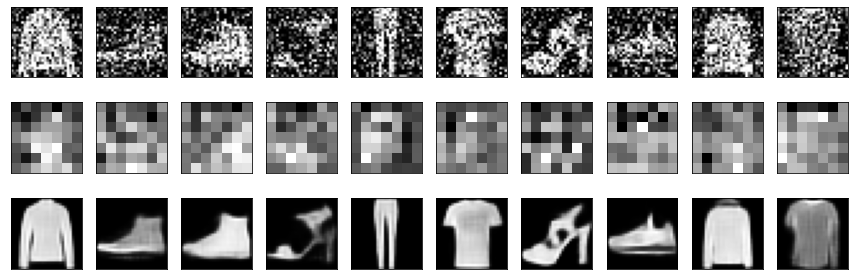

In [14]:
# take 1 batch of the dataset
test_data = test_dataset.take(1)

# take the input images and put them in a list
output_samples = []
for input_image, image in tfds.as_numpy(test_data):
      output_samples = input_image

# pick 10 indices
idxs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# prepare test samples as a batch of 10 images
conv_output_samples = np.array(output_samples[idxs])
conv_output_samples = np.reshape(conv_output_samples, (10, 28, 28, 1))

# get the encoder ouput
encoded = convolutional_encoder_model.predict(conv_output_samples)

# get a prediction for some values in the dataset
predicted = convolutional_model.predict(conv_output_samples)

# display the samples, encodings and decoded values!
display_results(conv_output_samples, encoded, predicted, enc_shape=(7, 7))

In [15]:
encoded.shape

(10, 7, 7, 1)